/home/xiangcen/Software/miniconda3/envs/llm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100
['/raid/candi/xiangcen/patient_level/promise_patient_level/39.h5', '/raid/candi/xiangcen/patient_level/promise_patient_level/15.h5', '/raid/candi/xiangcen/patient_level/promise_patient_level/558.h5']
['/raid/candi/xiangcen/patient_level/promise_patient_level/369.h5', '/raid/candi/xiangcen/patient_level/promise_patient_level/529.h5', '/raid/candi/xiangcen/patient_level/promise_patient_level/300.h5', '/raid/candi/xiangcen/patient_level/promise_patient_level/245.h5']


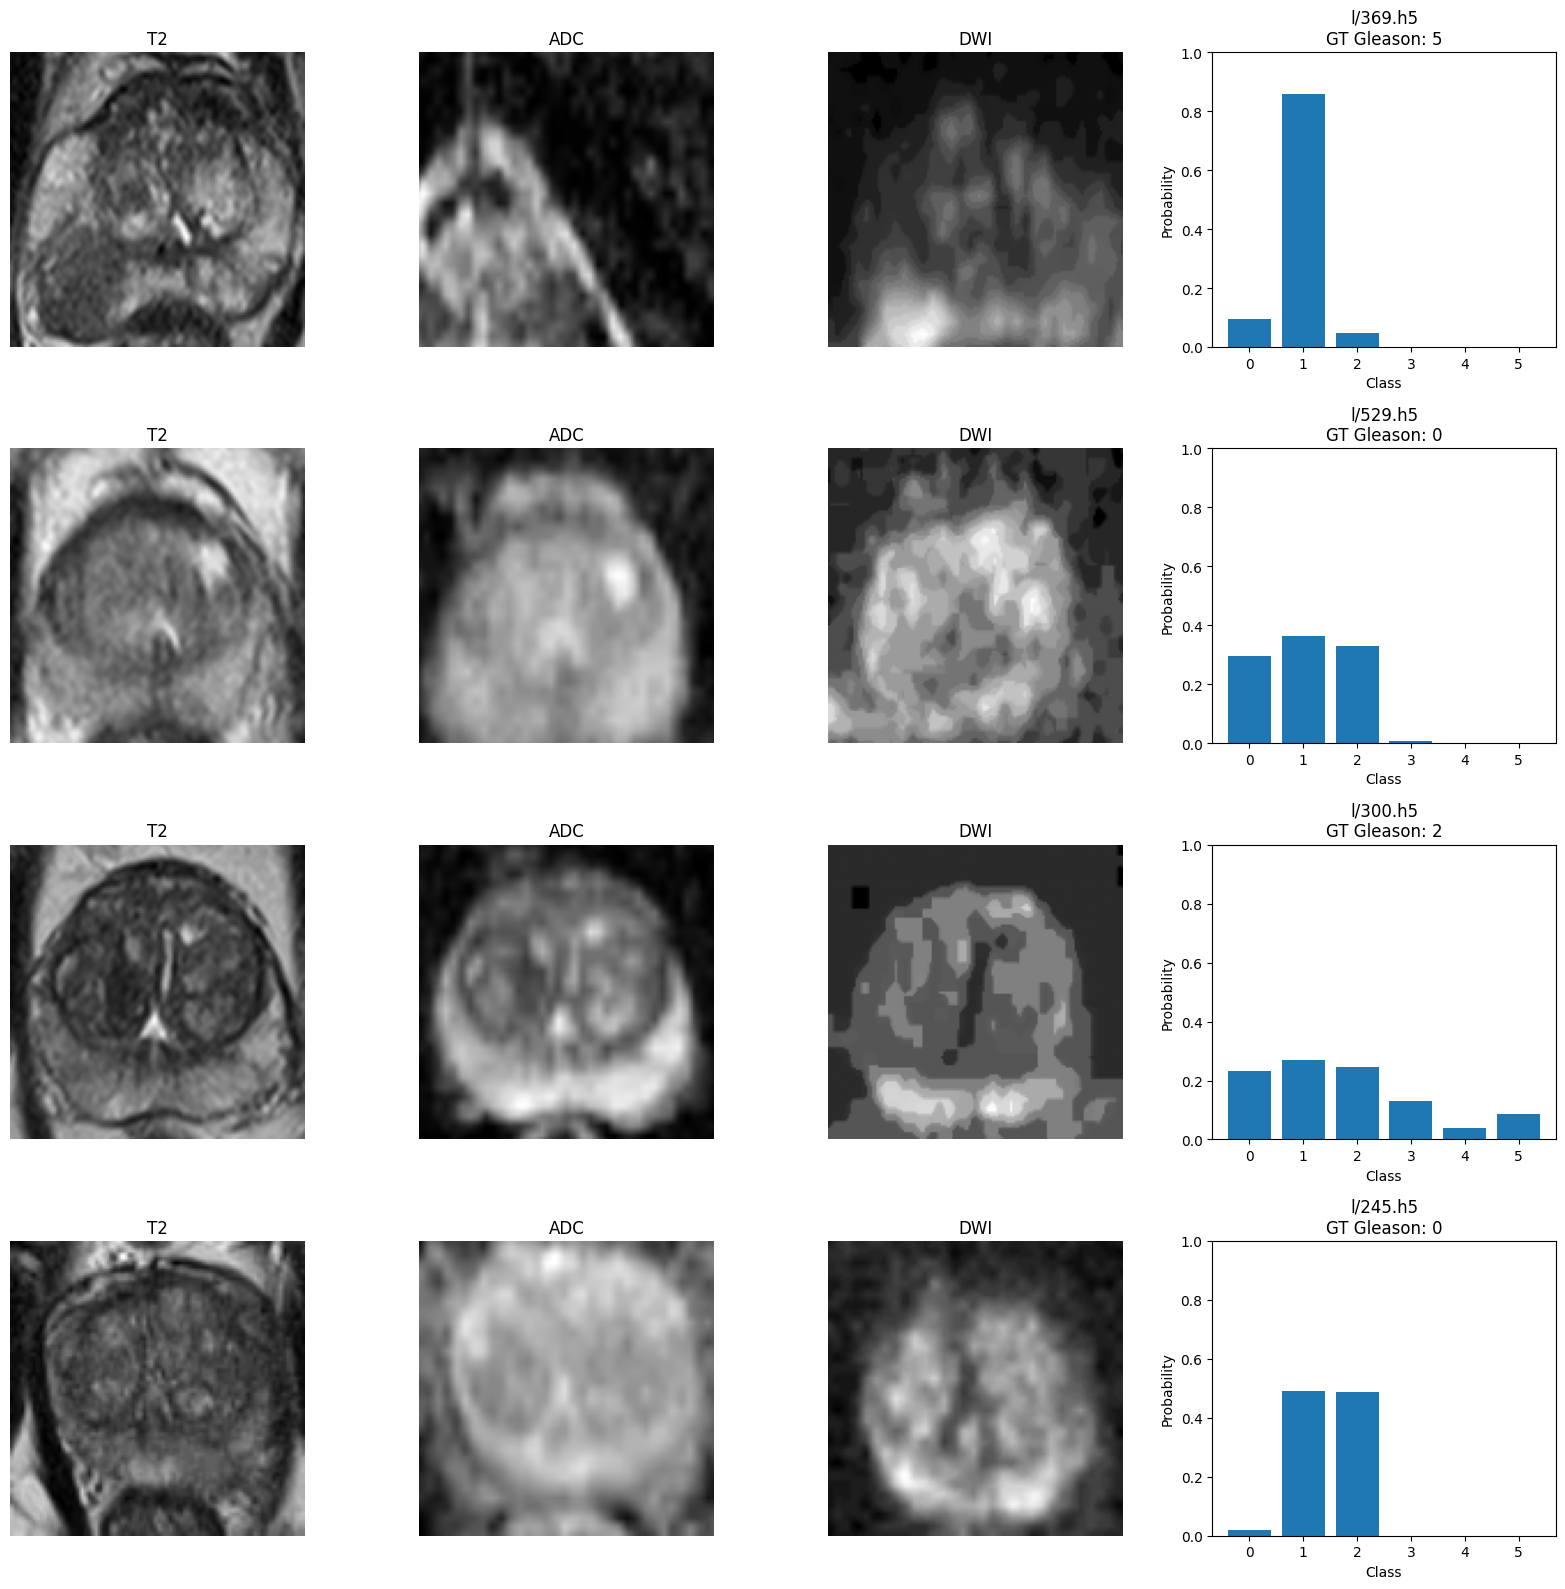

In [1]:
import os
from TrainInference import data_spilt, ReadH5Pkld, get_loader
from TrainInference import data_all, get_roc, inference_radiologist

import random


import torch

import time

from vit_classifier import vit_classifier, apply_lora

import matplotlib.pyplot as plt

device = 'cuda:0'
seed = 325





train_list, inference_list = data_spilt('/raid/candi/xiangcen/patient_level/promise_patient_level', 462, seed)

print(len(inference_list))

inference_transform = ReadH5Pkld()




model = vit_classifier(6)

model.load_state_dict(torch.load('/home/xiangcen/PatientBiopsyDetect/models/model_weights_pirAgle_68.pth', map_location=device))

model.to(device)


print(inference_list[:3])
num_display = 4
random.seed(time.time())  # re-seed using current time
data_dirs = random.sample(inference_list, k=num_display)
print(data_dirs)
fig, axes = plt.subplots(num_display, 4, figsize=(16, 4 * num_display))  
# 4 columns: T2, ADC, DWI, Bar chart

with torch.no_grad():
    for i in range(num_display):
        batch = inference_transform(data_dirs[i])
        img = batch['img'].to(device).unsqueeze(0)
        
        
        
        gleason = batch['gleason']
        output = model(img)
        prob = torch.softmax(output, dim=-1).squeeze(0).cpu().detach() # on dim tensor

        
        index = 32
        t2 = img[0, 0, ..., index].cpu().detach()
        adc = img[0, 1, ..., index].cpu().detach()
        dwi = img[0, 2, ..., index].cpu().detach()

        axes[i, 0].imshow(t2, cmap="gray")
        axes[i, 0].set_title("T2")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(adc, cmap="gray")
        axes[i, 1].set_title("ADC")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(dwi, cmap="gray")
        axes[i, 2].set_title("DWI")
        axes[i, 2].axis("off")

        # plot bar chart
        axes[i, 3].bar(range(len(prob)), prob)
        axes[i, 3].set_ylim(0, 1)
        axes[i, 3].set_xticks(range(len(prob)))
        axes[i, 3].set_xlabel("Class")
        axes[i, 3].set_ylabel("Probability")
        axes[i, 3].set_title(f"{data_dirs[i][-8:]}\nGT Gleason: {gleason}")

plt.tight_layout()
plt.show()